In [67]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam


from absl import app

# logging
import wandb
from datetime import datetime

In [68]:
latent_dim=515

In [81]:
sobel=True
input_dim = (224, 224, 3)
img_wd = "/home/aogorodnikov/data_aae"
batch = 56
latent_dim = 2
epoch = 10
adversarial=True
out="~/aae/"
verbose=True
# initialize monitoring with WandB





In [82]:
## ENCODER
encoder = Sequential()

if sobel:
    # Layer 1
    encoder.add(Conv2D(1, kernel_size=(1, 1), strides=(1, 1), input_shape=input_dim,
                       data_format="channels_last"))
    encoder.add(Conv2D(2, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    encoder.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                       data_format="channels_last"))
else:
    # Layer 1
    encoder.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), input_shape=input_dim, activation='relu',
                       data_format="channels_last"))





encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))
encoder.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
# Layer 2
encoder.add(Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))
encoder.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
encoder.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))

# Layer 4
encoder.add(Conv2D(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))

# Layer 5
encoder.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))
encoder.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same"))

# Dense
encoder.add(Flatten())
encoder.add(Dropout(rate=0.5))
encoder.add(Dense(4096, activation='relu'))
encoder.add(Dropout(rate=0.5))
encoder.add(Dense(4096, activation='relu'))
encoder.add(BatchNormalization(axis=-1, momentum=0.1, epsilon=1e-5))
encoder.add(Dense(latent_dim, activation=None))

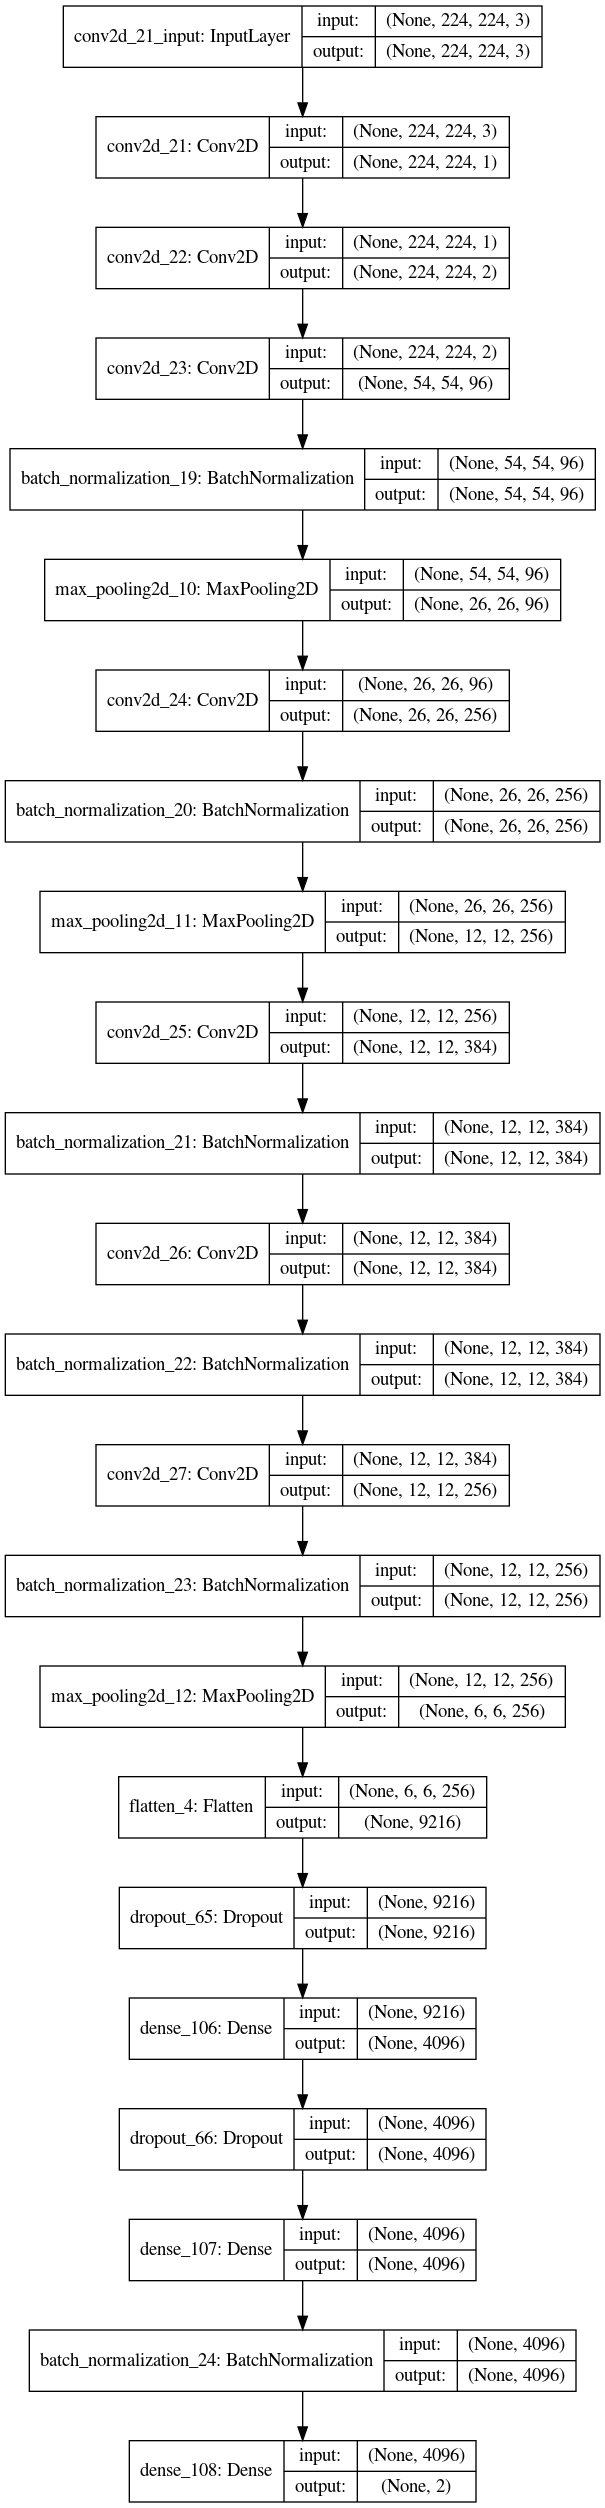

In [83]:
plot_model(encoder, show_shapes=True)

In [84]:
## DECODER
# Dense
decoder = Sequential()
decoder.add(Dense(4096, input_shape=(latent_dim,), activation='relu'))
decoder.add(Dropout(rate=0.5))
decoder.add(Dense(4096, activation='relu'))
decoder.add(Dropout(rate=0.5))
decoder.add(Dense(9216, activation='relu'))

# Conv
decoder.add(Reshape((6, 6, 256)))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2DTranspose(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
decoder.add(Conv2DTranspose(384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
decoder.add(Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='valid', activation='relu'))
decoder.add(Conv2DTranspose(96, kernel_size=(4, 4), strides=(2, 2), padding='valid', activation='relu'))
decoder.add(Conv2DTranspose(3, kernel_size=(12, 12), strides=(4, 4), padding='valid', activation='relu'))
#decoder.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid'))





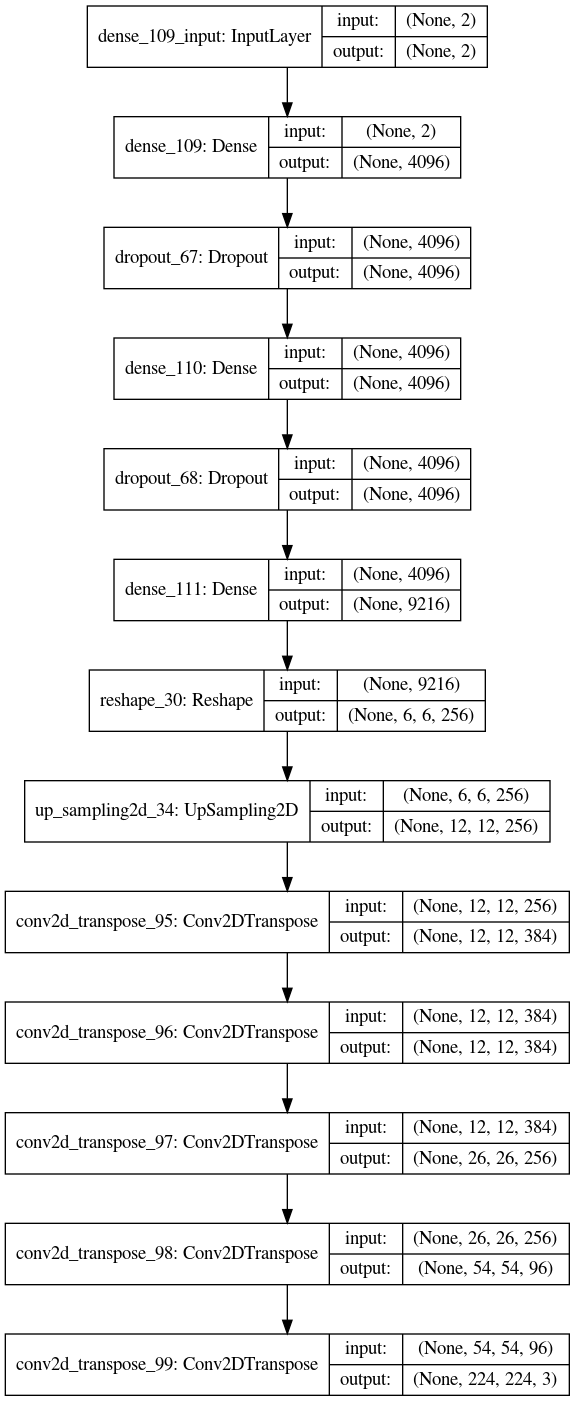

In [85]:
plot_model(decoder, show_shapes=True)

In [86]:
autoencoder_input = Input(shape=input_dim)
generator_input = Input(shape=input_dim)
if adversarial:
    discriminator = Sequential()
    discriminator.add(Dense(4096, input_shape=(latent_dim,), activation='relu'))
    discriminator.add(Dense(4096, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))



autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])

if adversarial:
    discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])
    discriminator.trainable = False
    generator = Model(generator_input, discriminator(encoder(generator_input)))
    generator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

if verbose:
    print("Autoencoder Architecture")
    print(autoencoder.summary())
    if adversarial:
        print("Discriminator Architecture")
        print(discriminator.summary())
        print("Generator Architecture")
        print(generator.summary())


Autoencoder Architecture
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_39 (Sequential)   (None, 2)                 58299834  
_________________________________________________________________
sequential_40 (Sequential)   (None, 224, 224, 3)       58772067  
Total params: 117,071,901
Trainable params: 117,060,957
Non-trainable params: 10,944
_________________________________________________________________
None
Discriminator Architecture
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 4096)              12288     
_________________________________________________________________
dense_113 (Dense)         

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [87]:

def train(train_data, out, latent_dim, n_epochs, autoencoder, discriminator, generator, encoder, decoder,
          adversarial = True):
    '''
    Function to train autoencoder. Arguments will be taken from argparse
    :param train_data: input data from flow_from_directory
    :param out: dir to save the models
    :param latent_dim: number of latent dimensions
    :param n_epochs: Number of epochs
    :param autoencoder: created autoencoder model
    :param discriminator: created discriminator model
    :param generator: created generator model
    :param encoder: created encoder part of autoencoder
    :param decoder: created decoder part of autoencoder
    :param adversarial: make adversarial model
    :return: trained encoder, decoder, discriminator and generator
    '''
    for epoch in np.arange(1, n_epochs + 1):
        autoencoder_losses = []
        if adversarial:
            discriminator_losses = []
            generator_losses = []
        autoencoder_history = autoencoder.fit_generator(train_data, epochs=1)
        if adversarial:
            batch_index = 0
            discriminator_batch_losses = []
            generator_batch_losses = []
            while batch_index <= train_data.batch_index:
                data = train_data.next()
                data_list = data[0]
                data_size = len(data_list)
                fake_latent = encoder.predict(data_list)
                discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
                discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
                discriminator_history = discriminator.fit(x=discriminator_input, y=discriminator_labels, epochs=1,
                                                          batch_size=data_size, validation_split=0.0, verbose=0)
                generator_history = generator.fit(data_list, y=np.ones((data_size, 1)), epochs=1,
                                                  batch_size=data_size, validation_split=0.0, verbose=0)
                batch_index = batch_index + 1
                discriminator_batch_losses.append(discriminator_history.history["loss"])
                generator_batch_losses.append(generator_history.history["loss"])
        autoencoder_losses.append(autoencoder_history.history["loss"])
        # WandB logging
        if adversarial:
            discriminator_losses.append(np.mean(discriminator_batch_losses))
            generator_losses.append(np.mean(generator_batch_losses))
            print("generator_loss = {}\n"
                  "generator_acc = {}".format(
                generator_history.history["loss"],
                generator_history.history["acc"]
            ))
            # WandB logging
            wandb.log({"phase": epoch,
                       "ae_train_loss": autoencoder_history.history["loss"],
                       "ae_train_acc": autoencoder_history.history["acc"],
                       "gen_train_loss": generator_history.history["loss"],
                       "gen_train_acc": generator_history.history["acc"]}, step=epoch)
        else:
            wandb.log({"phase": epoch,
                       "ae_train_loss": autoencoder_history.history["loss"],
                       "ae_train_acc": autoencoder_history.history["acc"]}, step=epoch)
        if epoch % 50 == 0:
            print("\nSaving models...")
            encoder.save(os.path.join(out, 'encoder.h5'))
            decoder.save(os.path.join(out, 'decoder.h5'))
            if adversarial:
                discriminator.save(os.path.join(out, 'discriminator.h5'))
                generator.save(os.path.join(out, 'generator.h5'))
    encoder.save(os.path.join(out, 'encoder.h5'))
    decoder.save(os.path.join(out, 'decoder.h5'))
    if adversarial:
        discriminator.save(os.path.join(out, 'discriminator.h5'))
        generator.save(os.path.join(out, 'generator.h5'))


In [88]:
# LOAD DATA
data_loader = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 1083 images belonging to 1 classes.


In [89]:
# training mode
train(train_data=train_data, out=out,
    latent_dim=latent_dim, n_epochs=epoch,
    autoencoder=autoencoder, discriminator=discriminator,
    generator=generator, encoder=encoder, decoder=decoder,
    adversarial=adversarial)


Epoch 1/1


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


20/20 [==============================] - 122s 6s/step - loss: 857.3574 - acc: 0.3479
generator_loss = [2.022028684616089]
generator_acc = [0.15789473056793213]


ValueError: You must call `wandb.init` in the same process before calling log